## Importing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/ML Datasets/Fire Detection/Training Dataset.zip"

In [ ]:
!unzip "/content/drive/MyDrive/ML Datasets/Fire Detection/Test Dataset.zip"

## Preprocessing

In [ ]:
import tensorflow as tf
tf.__version__
from matplotlib import pyplot as plt
import math

Training Set

In [ ]:
training_iamge_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [ ]:
training_dataset = training_iamge_data_generator.flow_from_directory(
    '/content/Training Dataset', 
    target_size=(224, 224), batch_size=32, class_mode='binary')

Found 2425 images belonging to 2 classes.


Test Set

In [ ]:
test_image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [ ]:
test_dataset = test_image_data_generator.flow_from_directory(
    '/content/Test Dataset 2', 
    target_size=(224, 224), batch_size=32, class_mode='binary')

Found 651 images belonging to 2 classes.


## Building CNN

In [ ]:
kernel_init = tf.keras.initializers.glorot_uniform()
bias_init = tf.keras.initializers.Constant(value=0.2)

In [ ]:
def get_inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_conv,
                     name=None):
    
    conv_1x1 = tf.keras.layers.Conv2D(
        filters=filters_1x1, kernel_size=(1, 1), padding='same', activation='relu', 
        kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3_reduce = tf.keras.layers.Conv2D(
        filters=filters_3x3_reduce, kernel_size=(1, 1), padding='same', activation='relu', 
        kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = tf.keras.layers.Conv2D(
        filters=filters_3x3, kernel_size=(3, 3), padding='same', activation='relu', 
        kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3_reduce)

    conv_5x5_redude = tf.keras.layers.Conv2D(
        filters=filters_5x5_reduce, kernel_size=(1, 1), padding='same', activation='relu', 
        kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = tf.keras.layers.Conv2D(
        filters=filters_5x5, kernel_size=(5, 5), padding='same', activation='relu', 
        kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5_redude)

    pool = tf.keras.layers.MaxPool2D(
        pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    pool_conv = tf.keras.layers.Conv2D(
        filters=filters_pool_conv, kernel_size=(1, 1), padding='same', activation='relu', 
        kernel_initializer=kernel_init, bias_initializer=bias_init)(pool)

    output = tf.keras.layers.concatenate(
        [conv_1x1, conv_3x3, conv_5x5, pool_conv], axis=3, name=name)
    
    return output

In [ ]:
input = tf.keras.Input(shape=(224, 224, 3))

In [ ]:
conv_1_7x7_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(7, 7), padding='same', 
    strides=(2, 2), activation='relu', name='conv_1_7x7_2', kernel_initializer=kernel_init, 
    bias_initializer=bias_init)(input)

max_pool_1_3x3_2 = tf.keras.layers.MaxPool2D(
    pool_size=(3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3_2')(conv_1_7x7_2)

conv_2a_3x3_1 = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(1, 1), padding='same', strides=(1, 1), activation='relu', 
    name='conv_2a_3x3_1')(max_pool_1_3x3_2)

conv_2b_3x3_1 = tf.keras.layers.Conv2D(
    filters=192, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu', 
    name='conv_2b_3x3_1')(conv_2a_3x3_1)

max_pool_2_3x3_2 = tf.keras.layers.MaxPool2D(
    pool_size=(3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3_2')(conv_2b_3x3_1)

inception_3a = get_inception_module(max_pool_2_3x3_2,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_conv=32,
                     name='inception_3a')

inception_3b = get_inception_module(inception_3a,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_conv=64,
                     name='inception_3b')

max_pool_3_3x3_2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3_2')(inception_3b)

inception_4a = get_inception_module(max_pool_3_3x3_2,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_conv=64,
                     name='inception_4a')

avg_pool_5_3x3_1 = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool_5_3x3_1')(inception_4a)

dropout = tf.keras.layers.Dropout(0.4)(avg_pool_5_3x3_1)

output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dropout)

In [ ]:
model = tf.keras.models.Model(input, [output], name='fire-detection-model')

In [ ]:
model.summary()

Model: "fire-detection-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7_2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3_2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7_2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3_1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3_2[0][0]           
_______________________________________________________________________________

## Training

In [ ]:
learning_rate = 0.07

def decay_func(epoch, steps=100):
    initial_lrate = learning_rate
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=False)

learningRateScheduler = tf.keras.callbacks.LearningRateScheduler(decay_func, verbose=1)

precision = tf.keras.metrics.Precision()

recall = tf.keras.metrics.Recall()

In [ ]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', precision, recall])

In [ ]:
history = model.fit(x=training_dataset, validation_data=test_dataset, epochs=50, callbacks=[learningRateScheduler])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.07.
Epoch 1/50
76/76 [==============================] - 67s 879ms/step - loss: 0.7054 - accuracy: 0.5913 - precision: 0.6152 - recall: 0.6364 - val_loss: 0.8465 - val_accuracy: 0.1690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: LearningRateScheduler reducing learning rate to 0.07.
Epoch 2/50
76/76 [==============================] - 67s 880ms/step - loss: 0.6378 - accuracy: 0.6474 - precision: 0.6692 - recall: 0.6779 - val_loss: 0.4057 - val_accuracy: 0.8418 - val_precision: 0.9011 - val_recall: 0.9094

Epoch 00003: LearningRateScheduler reducing learning rate to 0.07.
Epoch 3/50
76/76 [==============================] - 67s 884ms/step - loss: 0.5832 - accuracy: 0.6936 - precision: 0.7279 - recall: 0.6849 - val_loss: 0.3503 - val_accuracy: 0.8495 - val_precision: 0.8852 - val_recall: 0.9409

Epoch 00004: LearningRateScheduler reducing learning rate to 0.07.
Epoch 4/50
76/76 [===========================

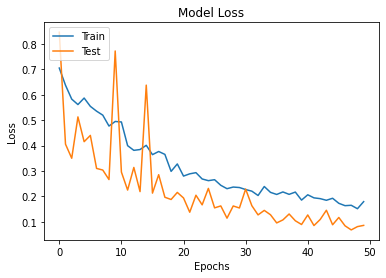

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

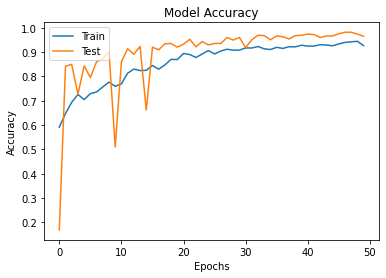

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

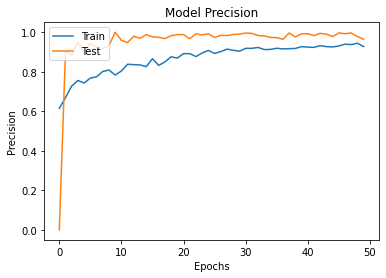

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

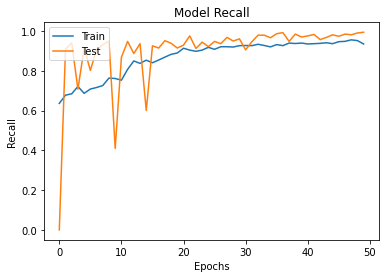

In [ ]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save("fire-detection")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: fire-detection/assets


In [ ]:
model.save_weights("saved-weights")

## Statistics

In [ ]:
import statistics

In [ ]:
mean_loss = statistics.mean(history.history['val_loss'])
variance_loss = statistics.variance(history.history['val_loss'])
mean_accuracy = statistics.mean(history.history['val_accuracy'])
variance_accuracy = statistics.variance(history.history['val_accuracy'])
mean_precision = statistics.mean(history.history['val_precision'])
variance_precision = statistics.variance(history.history['val_precision'])
mean_recall = statistics.mean(history.history['val_recall'])
variance_recall = statistics.variance(history.history['val_recall'])

In [ ]:
print('Loss : Mean = {}, Variance = {}'.format(mean_loss, variance_loss))
print('Accuracy : Mean = {}, Variance = {}'.format(mean_accuracy, variance_accuracy))
print('Precision : Mean = {}, Variance = {}'.format(mean_precision, variance_precision))
print('Recall : Mean = {}, Variance = {}'.format(mean_recall, variance_recall))

Loss : Mean = 0.22821727856993676, Variance = 0.02882151264889248
Accuracy : Mean = 0.8990476152300835, Variance = 0.01852390821578078
Precision : Mean = 0.9525615060329438, Variance = 0.01963160885040237
Recall : Mean = 0.9053604429960251, Variance = 0.027305761976885175


## Validation

In [ ]:
model.evaluate(test_dataset)

21/21 [==============================] - 13s 597ms/step - loss: 0.0827 - accuracy: 0.9662 - precision: 0.9659 - recall: 0.9945


[0.08265287429094315,
 0.9662058353424072,
 0.9658886790275574,
 0.9944547414779663]